### 経済センサスデータを用いた簡易住宅地地価予測

In [ ]:
!python -m pip install pandas geopandas contextily matplotlib pygeos scikit-learn

In [62]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [2]:
# 経済センサスメッシュデータの準備
mesh = gpd.read_file('data/HDDSWH5339/MESH05339.shp', crs=4612).to_crs(2451)
mesh = mesh[['KEY_CODE', 'geometry']]
mesh.KEY_CODE = mesh.KEY_CODE.astype(str)
keizai = pd.read_csv("data/tblT000389H5339.txt", encoding='sjis', skiprows=1)
keizai.columns = ['KEY_CODE', 'company', 'people']
keizai.KEY_CODE = keizai.KEY_CODE.astype(str)
keizai_mesh = pd.merge(mesh, keizai, on='KEY_CODE')

In [3]:
# 公示地価データの準備
chika = gpd.read_file('data/tokyo-koji/L01-22_13.shp', crs=4612).to_crs(2451)
chika = chika[(chika.L01_027 == '住宅') & (chika.L01_049 > 700) & (chika.L01_049 < 1300)]
chika = chika[['L01_006', 'L01_026', 'L01_049', 'geometry']]
chika.columns = ['price', 'menseki', 'station', 'geometry']
chika['pm'] = chika.price / chika.menseki
chika['p10'] = np.log10(chika.pm)
# chika['tokyo'] = chika.geometry.distance(keizai_mesh.sort_values('people', ascending=False).geometry.values[0])

<AxesSubplot:>

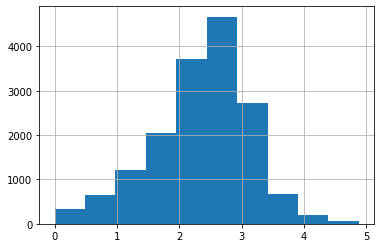

In [19]:
x = pd.Series(np.log10(keizai_mesh.people, where=keizai_mesh.people>0))
x[x > 0].hist()

In [96]:
chikap = chika.copy()
ans = []
keizai2 = keizai_mesh[keizai_mesh.people > 7500]
for row in chikap.geometry:
    x = []
    for g, p in zip(keizai2.geometry.centroid, keizai2.people):
        x.append(p / ((row.distance(g) ** 1.5) + 250))
    ans.append(sum(x))
chikap['keizai'] = ans
chikap['keizai10'] = np.log10(chikap.keizai)
chikap.sort_values('keizai10', ascending=False)

,price,menseki,station,geometry,pm,p10,tokyo,keizai,keizai10
830,1420000,137,750,POINT (-11633.832 -37317.765),10364.963504,4.015568,5662.073961,30.918865,1.490224
820,1320000,249,900,POINT (-10461.234 -39498.025),5301.204819,3.724375,5956.390504,20.162572,1.304546
836,1270000,297,1100,POINT (-10654.077 -38324.527),4276.094276,3.631047,5310.718222,20.003038,1.301096
831,1740000,304,900,POINT (-12443.085 -38511.422),5723.684211,3.757676,6914.737582,19.051738,1.279935
145,1730000,380,760,POINT (-9114.738 -38911.946),4552.631579,3.658263,4648.572079,18.952369,1.277664
...,...,...,...,...,...,...,...,...,...
2511,66100,121,1200,POINT (-53810.837 -30068.397),546.280992,2.737416,47622.428827,0.511041,-0.291544
1863,90100,193,1100,POINT (-52516.111 -23680.614),466.839378,2.669167,47396.190571,0.499394,-0.301557
1883,92300,165,950,POINT (-52847.847 -23009.706),559.393939,2.747718,47877.881391,0.489807,-0.309975
1884,59000,165,1200,POINT (-54581.210 -23935.026),357.575758,2.553368,49351.399552,0.468296,-0.329480


0.6987583148852629 3.0640904737280055
0.6725555367576174


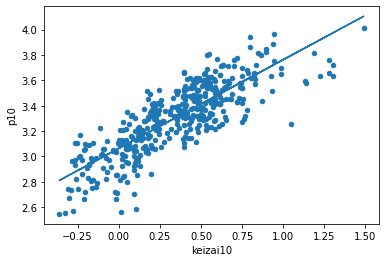

In [97]:
th = 4
ax = chikap[chikap.keizai10 < th].plot(x='keizai10', y='p10', kind='scatter')
x = chikap[chikap.keizai10 < th].keizai10
y = chikap[chikap.keizai10 < th].p10
a, b = np.polyfit(x, y, 1)
print(a, b)
ax.plot(x, a * x + b)
r2 = metrics.r2_score(y, a * x + b)
print(r2)
plt.show()

-1.9638837221121658e-05 3.723296948737169
0.6637930386396318


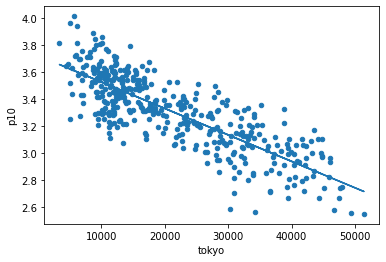

In [ ]:
ax = chika.plot(x='tokyo', y='p10', kind='scatter')
a, b = np.polyfit(chika.tokyo, chika.p10, 1)
print(a, b)
ax.plot(chika.tokyo, a * chika.tokyo + b)
r2 = metrics.r2_score(chika.p10, a * chika.tokyo + b)
print(r2)
plt.show()